In [5]:
import torch
from src.myChatGPT import *
from src.metrics import *
#from src.exp_weighted_pairs import *

import matplotlib.pyplot as plt
import numpy as np

In [54]:
with open("data/input.txt", "r", encoding = "utf-8") as f:
    text=f.read().lower()
    

In [55]:
def generate_bigrams(vocab_size, data):
    return torch.concatenate([data[:-1].unsqueeze(1),data[1:].unsqueeze(1)], dim=1) 

def generate_bigrams_id(vocab_size, data):
    return generate_bigrams(vocab_size, data) @ torch.tensor([1,vocab_size])

def count_sequence_of_bigrams(vocab_size, data):
    a = generate_bigrams_id(vocab_size, data)
    return torch.zeros(vocab_size*vocab_size, dtype=torch.long).scatter_add(0, a, torch.ones_like(a))

In [64]:
import bisect

def find_longest_token(s, vocab):
    last = -1
    for fin in range(0, len(s)):
        ss = s[:fin+1]
        #print("**", ss, "**")
        f = bisect.bisect_left(vocab, ss)
        if f>=len(vocab):
            break
        elif (vocab[f]==ss):            
            last=f
        else:
            break

    assert last!=-1
    return last

def tokenize(s, vocab):   
    a = zip(range(len(vocab)), vocab)
    v_id,v_vo = zip(*list(sorted(a, key=lambda a: a[1])))

    tokens = []
    i = 0
    while i<len(s):
        t = find_longest_token(s[i:], v_vo)
        tokens.append(v_id[t])
        i+= len(v_vo[t])
    return tokens
           


0 107814
1 106302
2 105012
3 103806
4 102916
5 102076
6 101357
7 100611
8 99745
9 99070
10 98501
11 97760
12 96983
13 96280
14 95714
15 95143
16 95143
17 94590
18 94070
19 93672
20 93329
21 92989
22 92589
23 92177
24 91799
25 91399
26 91001
27 90581
28 90038
29 89677
30 89288
31 89010
32 88669
33 88222
34 88222
35 88017
36 87672
37 87354
38 87354
39 87180
40 86924
41 86604
42 86316
43 86109
44 86043
45 85916
46 85689
47 85487
48 85247
49 85094
50 84906
51 84724
52 84724
53 84511
54 84331
55 84331
56 84231
57 84002
58 83876
59 83876
60 83632
61 83439
62 83310
63 83119
64 82981
65 82883
66 82883
67 82601
68 82424
69 82424
70 82369
71 82305
72 82227
73 82055
74 82055
75 81938
76 81796
77 81662
78 81662
79 81536
80 81430
81 81341
82 81306
83 81200
84 81045
85 80899
86 80838
87 80838
88 80691
89 80560
90 80445
91 80146
92 80035
93 80035
94 79932
95 79891
96 79891
97 79891
98 79766
99 79674
100 79558
101 79471
102 79426
103 79388
104 79186
105 79116
106 79002
107 78537
108 78494
109 78344
11

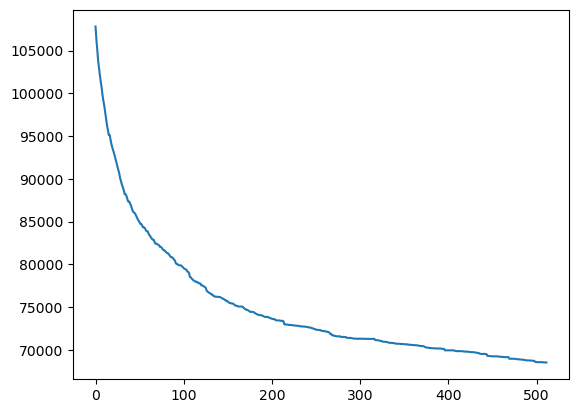

546371 ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'th', 'ou', 'an', 'er', 'in', 'the', 'or', 'en', 'ar', 'is', 'on', 'es', 'at', 'and', 'll', 'to', 'st', 'you', 'me', 'no', 'ha', 'ing', 'of', 'se', 'he', 'le', 'be', 'wi', 'wh', 're', 'it', 've', 'ro', 'my', 'ch', 'for', 'ce', 'as', 'ay', 'that', 'li', 'ed', 'ir', 'we', 'ld', 'ere', 'us', 'ut', 'ke', 'not', 'ri', 'de', 'lo', 'with', 'so', 'gh', 'your', 'ent', 'co', 'hi', 'thou', 'our', 'go', 'al', 'ow', 'ad', 'his', 'but', 'et', 'un', 'this', 'ther', 'est', 'ard', 'all', 'have', 'ly', 'ur', 'do', 'king', 'ght', 'ra', 'him', 'ord', 'od', 'ma', 'pe', 'ess', 'what', 'now', 'am', 'thy', 'ti', 'ver', 'sha', 'fe', 'ge', 'will', 'ould', 'are', 'ck', 'id', 'man', 'one', 'ue', 'fa', 'by', 'ne', 'io', 'la', 'her', 'pr', 'su', 'po', 'con', 'lord', 'if', 'ter', 'ta', 'shall', 'end', 'sh', 'mor', '

In [65]:
def bpe(data, vocab, exclude_list):
  
    vocab_size = len(vocab)

    bigrams = torch.concatenate([data[:-1].unsqueeze(1),data[1:].unsqueeze(1)], dim=1)
    bigrams_id = bigrams @ torch.tensor([1,vocab_size])
    bigrams_count = torch.zeros(vocab_size*vocab_size, dtype=torch.long).scatter_add(0, bigrams_id, torch.ones_like(bigrams_id))

    # dont consider bigrams that have the following tokens
    for i in range(len(bigrams_count)):
        a = i % vocab_size
        b = i // vocab_size
        if a in exclude_list or b in exclude_list:    
            bigrams_count[i]=0

    most_popular_bigram = bigrams_count.argmax()
    v1,v2 = (vocab[most_popular_bigram % vocab_size], vocab[most_popular_bigram//vocab_size])

    pos = ((bigrams_id == most_popular_bigram).nonzero(as_tuple=True)[0])

    mask = data>=0
    mask[pos] = False
    data[pos+1] = vocab_size
    
    #print(p)
    vocab.append("%s%s" % (v1,v2))
    return data[mask] , vocab


import matplotlib.pyplot as plt


t = Tokenizer(text)
l = int(len(text)*0.9)
traininig_text = text[:l]
validation_text = text[l:]


exclude_list = t.encode(" !,.\n?:;'")

data = torch.tensor(t.encode(traininig_text), dtype=torch.long)
data, vocab = bpe(data, t.vocab, exclude_list)

validation_loss = []

for i in range(512):
    data, vocab = bpe(data, vocab, exclude_list)
    tokens = tokenize(validation_text, vocab)
    validation_loss.append(len(tokens))
    print(i, len(tokens))


plt.plot(validation_loss)
plt.show()


##    #print()

print(len(data), vocab)


#print(",".join([ vocab[i] for i in tokens ]))


In [58]:
print("-".join([ vocab[i] for i in data ]))

#"ffdfdsA".lower()

first- -citizen-:-
-before- -we- -pro-ce-ed- -any- -f-ur-ther-,- -hear- -me- -speak-.-
-
-all-:-
-speak-,- -speak-.-
-
-first- -citizen-:-
-you- -are- -all- -res-ol-ved- -ra-ther- -to- -di-e- -than- -to- -f-am-ish-?-
-
-all-:-
-res-ol-ved-.- -res-ol-ved-.-
-
-first- -citizen-:-
-first-,- -you- -know- -ca-ius- -mar-c-ius- -is- -chi-ef- -en-e-my- -to- -the- -pe-o-ple-.-
-
-all-:-
-we- -know-'-t-,- -we- -know-'-t-.-
-
-first- -citizen-:-
-let- -us- -k-ill- -him-,- -and- -we-'-ll- -have- -cor-n- -at- -our- -own- -pri-ce-.-
-is-'-t- -a- -ver-di-ct-?-
-
-all-:-
-no- -more- -t-al-king- -on-'-t-;- -let- -it- -be- -done-:- -away-,- -away-!-
-
-second- -citizen-:-
-one- -word-,- -good- -citizen-s-.-
-
-first- -citizen-:-
-we- -are- -ac-coun-t-ed- -poor- -citizen-s-,- -the- -p-at-ri-ci-ans- -good-.-
-what- -au-th-or-ity- -s-ur-fe-it-s- -on- -would- -re-lie-ve- -us-:- -if- -they-
-would- -y-i-e-ld- -us- -but- -the- -su-per-fl-u-ity-,- -whi-le- -it- -were-
-who-l-es-o-me-,- -we- -m-ight- -gu-ess- -